# Drifter L2 data inertial oscillations filter 

- remove the wavelet component of a signal 
- apply a wavelet filter to remove inertial oscillations from drifters data
- for a given trajectory plot the drifter velocity vectors and the interpolated field vectors

- comparison : FIELD with/without SWOT  &
               DRIFTERS with/without filter

In [1]:
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import numpy as np
import xarray as xr
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

%matplotlib inline
from matplotlib import pyplot as plt

path_save_plot = './save_plots/save_plots_2024-06-13_DrifterL2_inertial_oscillations_filter/'

In [10]:
drifters_directory = '/home/bouxdecl/Documents/data/DRIFTERS'

## Data selection

In [11]:
L2_dir = drifters_directory + '/L2'
os.listdir(L2_dir)[:5]

['L2_svp_scripps_10min_lowess_10min_v0.nc',
 'L2_carthe_uwa_5min_variational_10min_v0.nc',
 'L2_svp_ogs_1h_variational_10min_v0.nc',
 'L2_svp_bcg_10min_variational_10min_v0.nc',
 'L2_svp_scripps_10min_lowess_30min_v0.nc']

filename convention : L1_type_source_aaaammjj_hhmmss_sampling.format

In [12]:
def file_selection_mediterranean(files):
    # only mediterranean (not containing 'uwa') 

    selected_files = []
    for file in files:
         if not file.count("uwa"):
            selected_files.append(file)
    return selected_files

def file_selection_by_method(files, method: str):
    # files from one interpolation method: 'variationnal' or 'lowess'

    selected_files = []
    for file in files:
         if file.count(method):
            selected_files.append(file)
    return selected_files

def file_selection_by_sampling(files, sampling: str):
    # files from one smooth L2 sampling: '10min', '30min', '1h' at the end of the file_name

    selected_files = []
    for file in files:
         if file[-11:].count(sampling):
            selected_files.append(file)
    return selected_files


In [13]:
mediterranea_files = file_selection_mediterranean(os.listdir(L2_dir))

file_lowess_10min = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_10min = file_selection_by_sampling(file_lowess_10min, "10min")

file_lowess_30min = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_30min = file_selection_by_sampling(file_lowess_30min, "30min")

file_lowess_1h = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_1h = file_selection_by_sampling(file_lowess_1h, "1h")

## One trajectory filtering

In [14]:
# load one file
file = 'L2_svp_ogs_10min_lowess_10min_v0.nc'
file = file_lowess_10min[8]


ds = xr.open_dataset(os.path.join(L2_dir, file))
ds_traj = ds.dropna(dim='time', how='any', subset=['u']).isel(id=0)#.isel(time=slice(1000, 2000))

In [15]:
def get_velocities_array(ds_traj, vector_spacing):
    time_vec = ds_traj.time.values[::vector_spacing]
    lat_vec  = ds_traj.lat.values[::vector_spacing]
    lon_vec  = ds_traj.lon.values[::vector_spacing]
    u_vec    = ds_traj.u.values[::vector_spacing]
    v_vec    = ds_traj.v.values[::vector_spacing]
    return time_vec, lat_vec, lon_vec, u_vec, v_vec

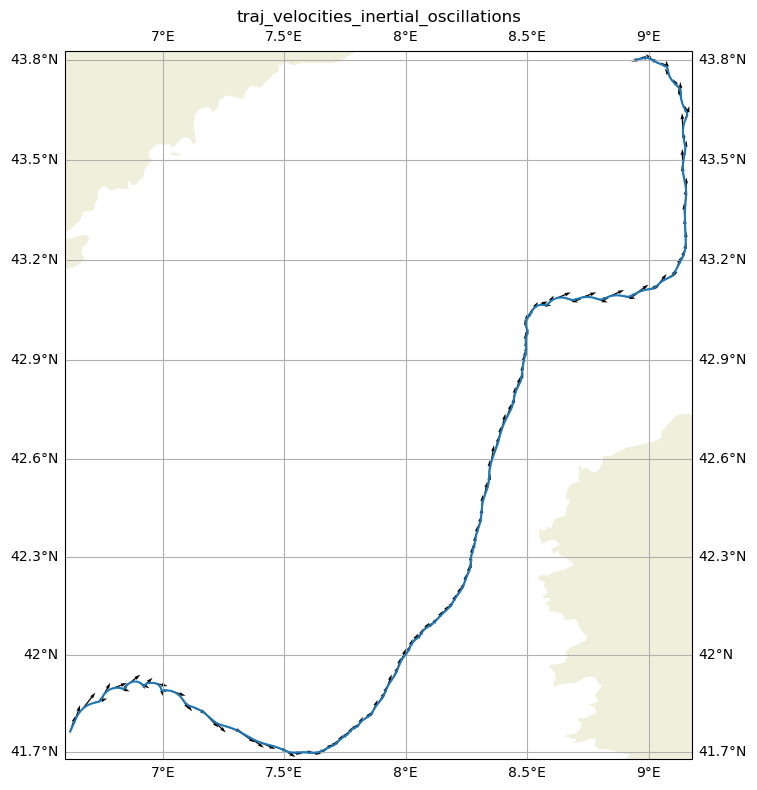

In [127]:
ds_traj = ds_traj
time_vec, lat_vec, lon_vec, u_vec, v_vec = get_velocities_array(ds_traj, vector_spacing = 30)
scale = 3e-5
width = 2e-3

# Plot the trajectory with the velocity vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)

# trajectory
ax.plot(ds_traj.lon, ds_traj.lat,transform=crs)
# vectors
ax.quiver(lon_vec, lat_vec, u_vec, v_vec, angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree())

plot_marge = 0.02
ax.set_extent([np.nanmin(lon_vec) - plot_marge, np.nanmax(lon_vec) + plot_marge, np.nanmin(lat_vec) - plot_marge, np.nanmax(lat_vec) + plot_marge], crs=ccrs.PlateCarree())

### SAVE
ax.set_title("traj_velocities_inertial_oscillations")
save_name = 'traj_velocities_inertial_oscillations.png'
plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

## Filter gaussian &/ wavelet order ? --> don't need wavelet if we just want the low frequencies

In [16]:
def _apply_transform(x, y, wavelet):
    '''
    apply wavelet transform and return the data without wavelet component
    '''

    n_points, n_wavelet_times = wavelet.shape
    
    #pass in local complex plane and padding
    X = x + 1j* y

    padd_width = n_wavelet_times -1   #half the number of points of the wavelet
    X_padded = np.pad(X, padd_width, mode='symmetric')
    
    #convolve
    X_oscil = X_padded*0.+np.nan
    for point in range(n_points):
        X_oscil = np.convolve(X_padded[:], wavelet[point, :], 'same')

    #remove pad and get processed values
    X_oscil = X_oscil[padd_width:-padd_width]
    
    x_process = (X - X_oscil).real
    y_process = (X - X_oscil).imag

    #remove offset
    x_process -= float((x_process - x).mean())
    y_process -= float((y_process - y).mean())

    return x_process, y_process


def wavelet_inertial_filter(x, y, lat, wavelet_width_fration = 0.5, plot_wavelet=False):

    time_step = float(x.time[1]- x.time[0])*1e-9
    # --- defines Morlet wavelet function (for each point because inertial oscillation are latitude dependant)

    #define tau_lat for each drifter point = period of the inertial oscillations
    tau_lat = 12.93447/np.sin(lat/180 * np.pi) *3600 #s
    fc_lat  = 1/tau_lat

    #wavelet parameters
    wavelet_width = tau_lat * wavelet_width_fration
    wavelet_span  = float(wavelet_width[0]) * 4   #wavelet window
    wavelet_resolution = time_step

    tt      = np.arange(-wavelet_span, wavelet_span+wavelet_resolution, wavelet_resolution)
    wavelet = (np.exp(-1j*2*np.pi*np.outer(fc_lat,tt))*np.exp(-np.outer(1/2*wavelet_width**-2,tt**2)))
    
    #normalization
    row_sums = np.sum(np.abs(wavelet), axis=1)[:, np.newaxis] + 1e-10
    wavelet = wavelet / row_sums 

    # --- data preprocessing

    x_process, y_process = _apply_transform(x, y, wavelet)


    if plot_wavelet:
        plt.plot(tt/float(tau_lat[0]), wavelet[0])

    return x_process, y_process


In [9]:
def gaussian_filter(x, gaussian_width_fraction=0.45):
    
    print(x.shape)
    
    time_step = float(ds_traj.u.time[1]- ds_traj.u.time[0])*1e-9  #s

    # defines gaussian
    tau = 12.93447/np.sin(40/180 * np.pi) *3600  #s : inertial period at 40°
    gaussian_width = gaussian_width_fraction * tau
    gaussian_window_width = 3*gaussian_width

    tt = np.arange(-gaussian_window_width, gaussian_window_width+time_step, time_step)
    
    gaussian = np.exp(-0.5 * (tt/gaussian_width)**2)
    gaussian = gaussian / np.sum(np.abs(gaussian))
    
    return np.convolve(x, gaussian, 'same')

In [10]:
u_process, v_process = wavelet_inertial_filter(ds_traj.u, ds_traj.v, ds_traj.lat, wavelet_width_fration = 0.5)

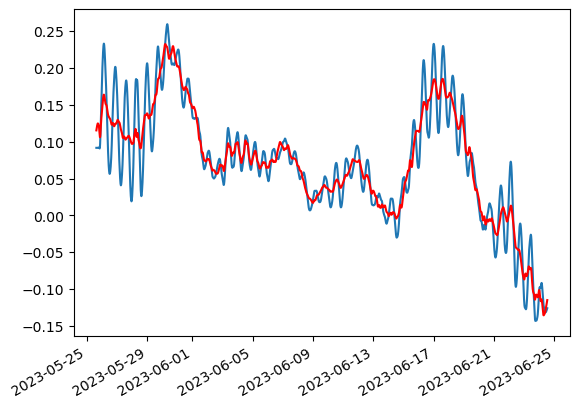

(4309,)
(4309,)
(4309,)
(4309,)


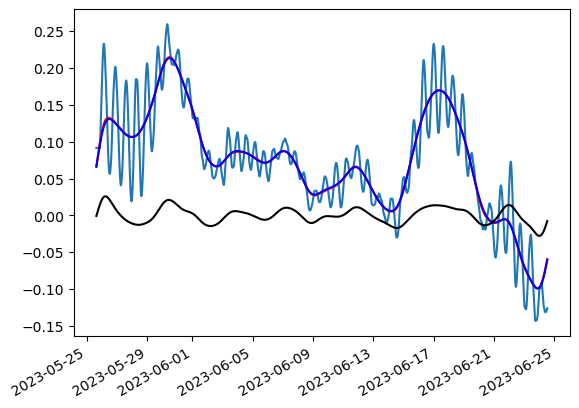

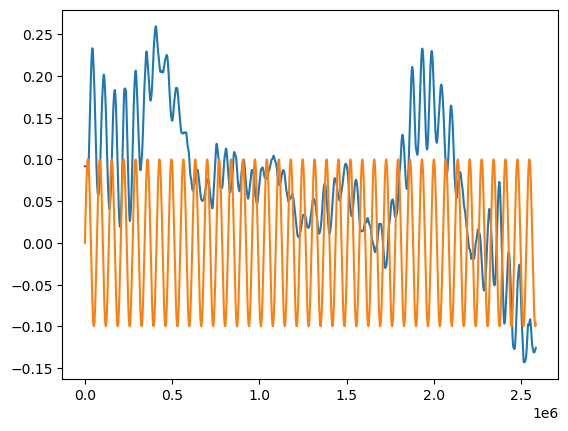

In [35]:
#only wavelet
time = ds_traj.time
plt.plot(time, ds_traj.u)
plt.plot(time, u_process, c='r')
plt.gcf().autofmt_xdate()

plt.show()

#only gaussian
time = ds_traj.time
plt.plot(time, ds_traj.u)
plt.plot(time, gaussian_filter(ds_traj.u, gaussian_width_fraction=0.5), c='r')
plt.plot(time, gaussian_filter(u_process, gaussian_width_fraction=0.5), c='b')
plt.plot(time, gaussian_filter(u_process, gaussian_width_fraction=0.5) - gaussian_filter(ds_traj.u, gaussian_width_fraction=1), c='black')
plt.gcf().autofmt_xdate()
plt.show()

t_array=np.arange(len(time))*600
plt.plot(t_array, ds_traj.u)
plt.plot(t_array, np.sin( 2*np.pi* t_array / (19*3600))*0.1 )


In [ ]:
sig = 

t = ds_traj.time


# Compute the FFT
fft_vals = np.fft.fft(sig)
fft_freqs = np.fft.fftfreq(len(fft_vals), 600)

# Only keep the positive half of the spectrum
positive_freqs = fft_freqs[:len(fft_freqs) // 2]
positive_fft_vals = np.abs(fft_vals[:len(fft_vals) // 2])

# Plot the original signal
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, sig)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()

# Plot the Fourier Transform
plt.subplot(2, 1, 2)
plt.loglog(positive_freqs, positive_fft_vals)
plt.axvline(1/(19.5*3600), c='grey', ls='--', label='inertial frequency')
plt.title('Fourier Transform')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid()

plt.tight_layout()

## Wavelet filter and visu

In [17]:
def _apply_transform(x, y, wavelet):
    '''
    apply wavelet transform and return the data without wavelet component
    '''

    n_points, n_wavelet_times = wavelet.shape
    
    #pass in local complex plane and padding
    X = x + 1j* y

    padd_width = n_wavelet_times -1   #half the number of points of the wavelet
    X_padded = np.pad(X, padd_width, mode='symmetric')
    
    #convolve
    X_oscil = X_padded*0.+np.nan
    for point in range(n_points):
        X_oscil = np.convolve(X_padded[:], wavelet[point, :], 'same')

    #remove pad and get processed values
    X_oscil = X_oscil[padd_width:-padd_width]
    
    x_process = (X - X_oscil).real
    y_process = (X - X_oscil).imag

    #remove offset
    x_process -= float((x_process - x).mean())
    y_process -= float((y_process - y).mean())

    return x_process, y_process


def wavelet_inertial_filter(ds_traj, wavelet_width_fration = 1, plot_wavelet=False):

    u = ds_traj.u
    v = ds_traj.v
    lon = ds_traj.lon
    lat = ds_traj.lat
    time_step = float(ds_traj.time[1]- ds_traj.time[0])*1e-9  #s

    # --- defines Morlet wavelet function (for each point because inertial oscillation are latitude dependant)

    #define tau_lat for each drifter point = period of the inertial oscillations
    tau_lat = 12.93447/np.sin(lat/180 * np.pi) *3600 #s
    fc_lat  = 1/tau_lat

    #wavelet parameters
    wavelet_width = tau_lat * wavelet_width_fration
    wavelet_span  = float(wavelet_width[0]) * 4   #wavelet window
    wavelet_resolution = time_step

    tt      = np.arange(-wavelet_span, wavelet_span+wavelet_resolution, wavelet_resolution)
    wavelet = (np.exp(-1j*2*np.pi*np.outer(fc_lat,tt))*np.exp(-np.outer(1/2*wavelet_width**-2,tt**2)))
    
    #normalization
    row_sums = np.sum(np.abs(wavelet), axis=1)[:, np.newaxis] + 1e-10
    wavelet = wavelet / row_sums 

    # --- data preprocessing

    u_process, v_process     = _apply_transform(u,   v,   wavelet)
    lon_process, lat_process = _apply_transform(lon, lat, wavelet)

    # --- save processed data
    ds_traj['u_process']   = ds_traj.u.copy(data= u_process)
    ds_traj['v_process']   = ds_traj.v.copy(data= v_process)
    ds_traj['lon_process'] = ds_traj.lon.copy(data= lon_process)
    ds_traj['lat_process'] = ds_traj.lat.copy(data= lat_process)

    if plot_wavelet:
        plt.plot(tt/float(tau_lat[0]), wavelet[0])

    return ds_traj


In [18]:
ds_traj_process = wavelet_inertial_filter(ds_traj, wavelet_width_fration=0.5, plot_wavelet=False)

In [74]:
def plot_wavelet_filter(x, x_process, time, name='x'):

    x_oscil = x_process - x 

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    axes[0].plot(ds_traj.time, x, c='black', label='raw data')
    axes[0].plot(ds_traj.time, x_process, c='red', label='processed data')
    #axes[0].plot(time, u_process_liss, c='darkblue', label='+ gaussian filtering')
    axes[0].set_title('Frequency filtering')
    axes[0].legend()
    plt.legend()
    #axes[0].gcf().autofmt_xdate()
    axes[1].plot(time, x, c='black', label='raw data')
    axes[1].plot(time, x_oscil, c='darkorange', label=' wavelet component')
    axes[1].set_title('Wavelet_component')
    axes[1].legend()

    plt.suptitle('Wavelet filter on '+ name)
    plt.legend()
    plt.gcf().autofmt_xdate()

        
    ### SAVE
    save_name = 'filtrage_wavelet_'+ name +'.png'
    plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)


In [21]:
time = ds_traj_process.time
u = ds_traj_process.u
v = ds_traj_process.v
u_process = ds_traj_process.u_process
v_process = ds_traj_process.v_process
lon = ds_traj_process.lon
lat = ds_traj_process.lat
lon_process = ds_traj_process.lon_process
lat_process = ds_traj_process.lat_process

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


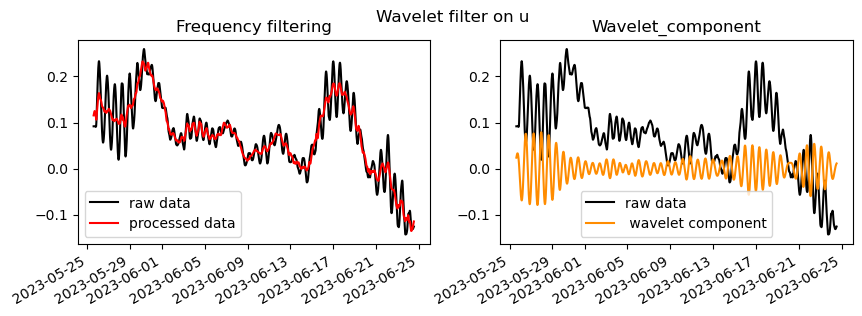

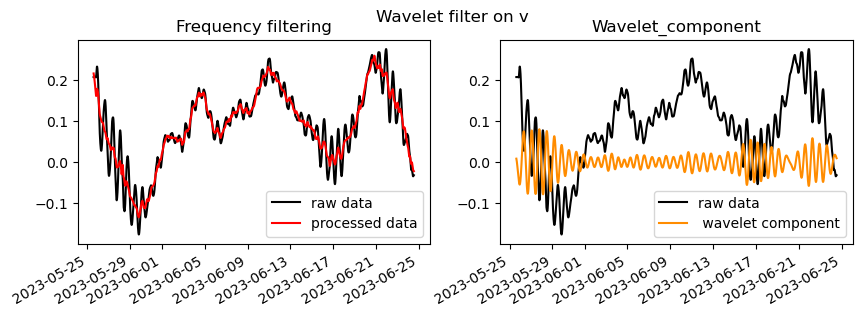

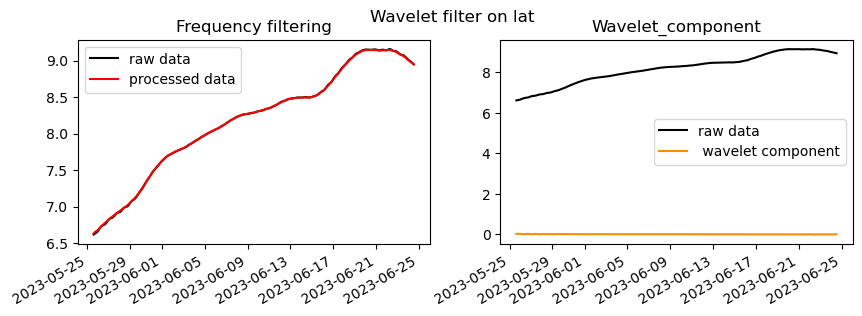

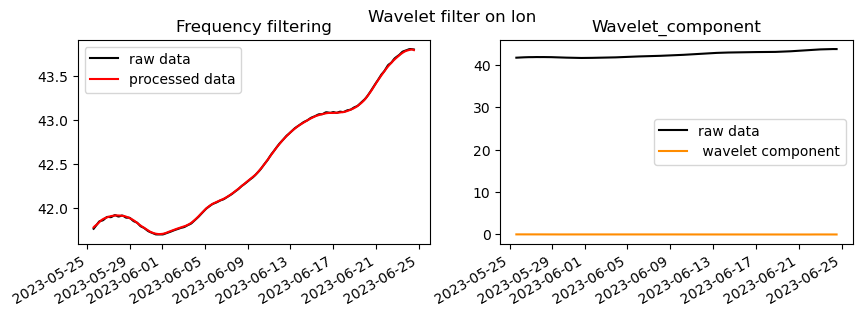

In [76]:
plot_wavelet_filter(u, u_process, time, 'u')
plot_wavelet_filter(v, v_process, time, 'v')
plot_wavelet_filter(lon, lon_process, time, 'lat')
plot_wavelet_filter(lat, lat_process, time, 'lon')

#### visu

In [26]:
vector_spacing = 50
u_process_vec = u_process[::vector_spacing]
v_process_vec = v_process[::vector_spacing]

' \n### SAVE\nax.set_title("traj_corrected_velocities_inertial_oscillations")\nsave_name = \'traj_corrected_velocities_inertial_oscillations.png\'\nplt.savefig(os.path.join(path_save_plot,save_name), bbox_inches=\'tight\', dpi = 300) '

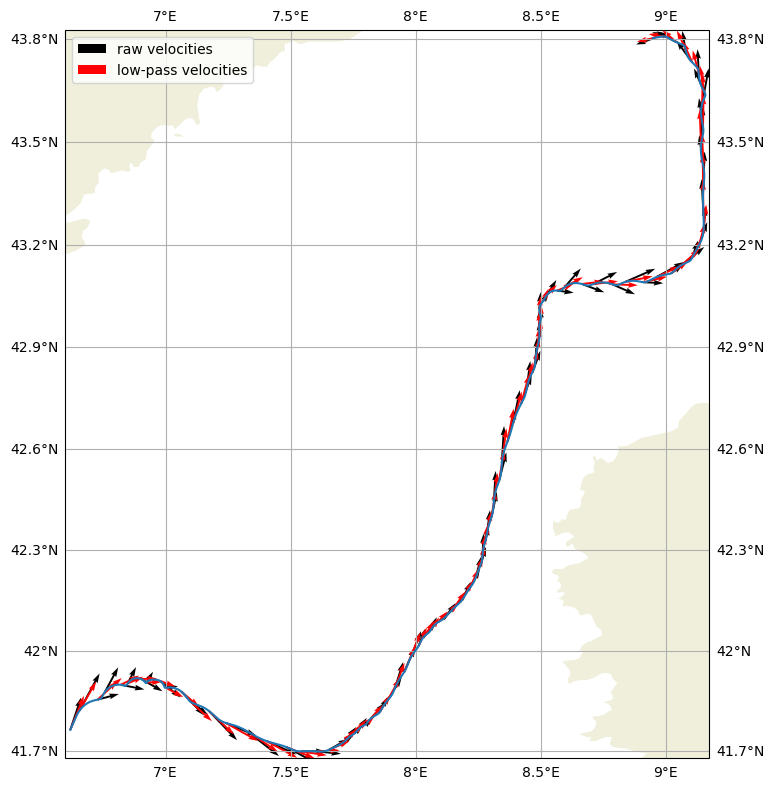

In [28]:
ds_traj = ds_traj
time_vec, lat_vec, lon_vec, u_vec, v_vec = get_velocities_array(ds_traj, vector_spacing = vector_spacing)
scale = 1.5e-5
width = 3e-3

# Plot the trajectory with the velocity vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)

# trajectory
ax.plot(ds_traj.lon, ds_traj.lat,transform=crs)
# vectors
ax.quiver(lon_vec, lat_vec, u_vec, v_vec, label='raw velocities', color='black', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree())
ax.quiver(lon_vec, lat_vec, u_process_vec, v_process_vec, label='low-pass velocities', color='r', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree())

plot_marge = 0.02
ax.set_extent([np.nanmin(lon_vec) - plot_marge, np.nanmax(lon_vec) + plot_marge, np.nanmin(lat_vec) - plot_marge, np.nanmax(lat_vec) + plot_marge], crs=ccrs.PlateCarree())

ax.legend()

""" 
### SAVE
ax.set_title("traj_corrected_velocities_inertial_oscillations")
save_name = 'traj_corrected_velocities_inertial_oscillations.png'
plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300) """

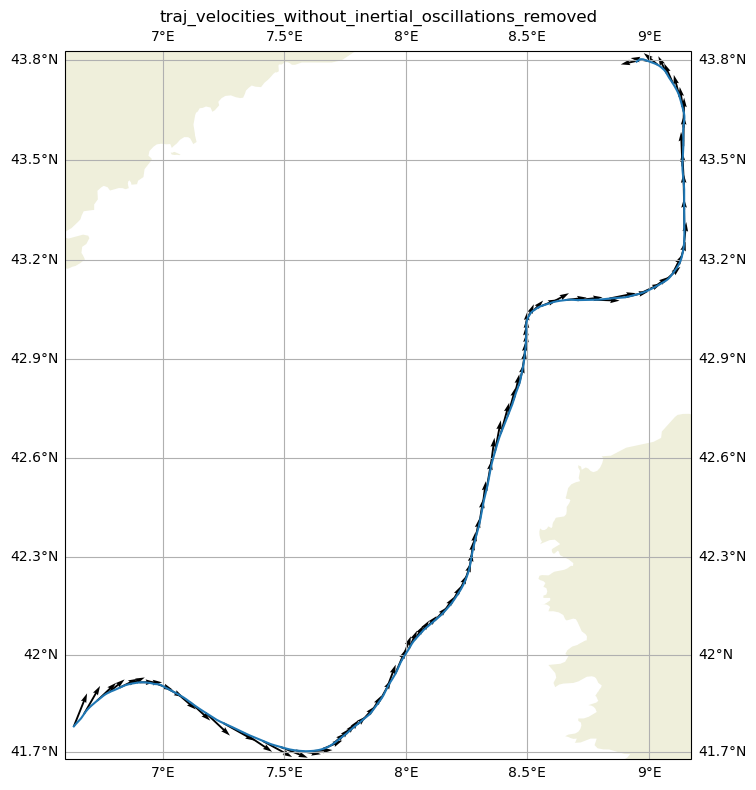

In [79]:
scale = 1.5e-5
width = 3e-3

# Plot the trajectory with the velocity vectors

fig = plt.figure(tight_layout=True, figsize=(8, 8))
crs = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True,)
ax.add_feature(cfeature.LAND,)

# trajectory
ax.plot(lon_process, lat_process, transform=crs)
# vectors
ax.quiver(lon_process[::vector_spacing], lat_process[::vector_spacing], u_process[::vector_spacing], v_process[::vector_spacing], 
          color='black', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree())

plot_marge = 0.02
ax.set_extent([np.nanmin(lon_vec) - plot_marge, np.nanmax(lon_vec) + plot_marge, np.nanmin(lat_vec) - plot_marge, np.nanmax(lat_vec) + plot_marge], crs=ccrs.PlateCarree())

### SAVE
ax.set_title("traj_velocities_without_inertial_oscillations_removed")
save_name = 'traj_corrected_velocities_inertial_oscillations_removed.png'
plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

## Example of complex low pass filter

In [24]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


In [17]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [22]:
# Sample rate and desired cutoff frequencies (in Hz)
fs = 500.0
cutoff = 50.0

# Generate a sample complex signal
T = 1.0  # seconds
n = int(T * fs)  # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# Create a complex signal with both real and imaginary parts
sig = np.exp(2j * np.pi * 7.0 * t) + 0.5 * np.sin(2 * np.pi * 80.0 * t) *np.exp(2j * np.pi * 2 * t)


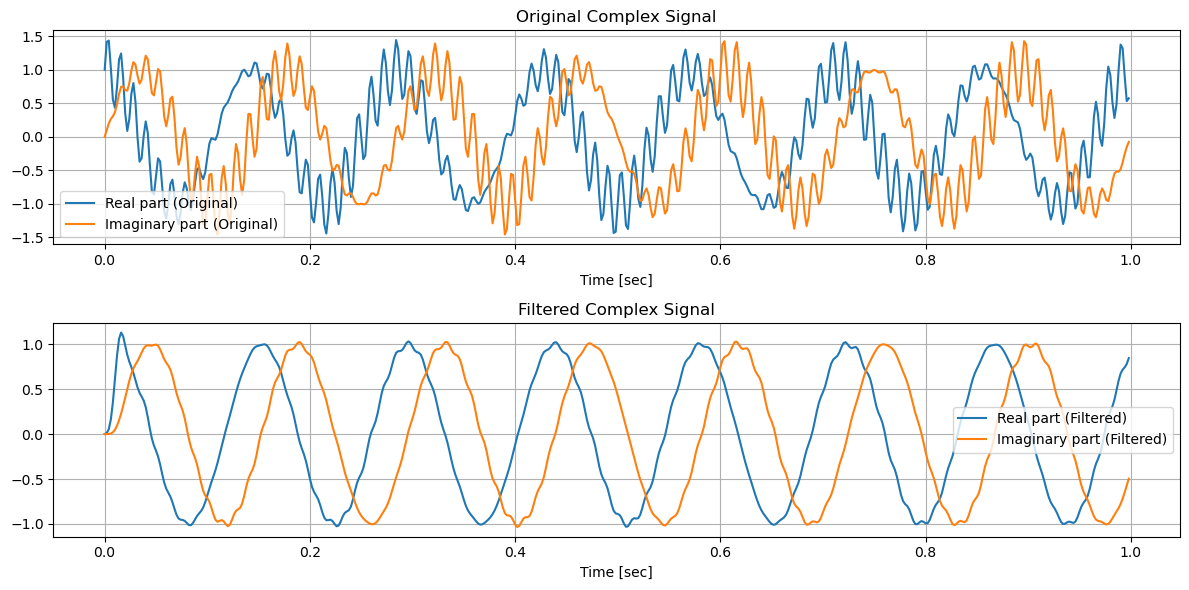

In [23]:
# Filter the complex signal
filtered_signal = butter_lowpass_filter(sig, cutoff, fs)

# Plot the original and filtered signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, np.real(sig), label='Real part (Original)')
plt.plot(t, np.imag(sig), label='Imaginary part (Original)')
plt.title('Original Complex Signal')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, np.real(filtered_signal), label='Real part (Filtered)')
plt.plot(t, np.imag(filtered_signal), label='Imaginary part (Filtered)')
plt.title('Filtered Complex Signal')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
